# Mean_Temp
##### *Diego Duarte 22075 -  Paula Barillas 22764*

### Analisis Exploratorio

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./data/monthly-mean-temp.csv", parse_dates=True)

print(df.head())

     Month  Temperature
0  1920-01         40.6
1  1920-02         40.8
2  1920-03         44.4
3  1920-04         46.7
4  1920-05         54.1


In [2]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
print(df.head())
print(df.info())


            Temperature
Month                  
1920-01-01         40.6
1920-02-01         40.8
1920-03-01         44.4
1920-04-01         46.7
1920-05-01         54.1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1920-01-01 to 1939-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None


In [3]:
print("Resumen estadístico:")
print(df['Temperature'].describe())

Resumen estadístico:
count    240.000000
mean      49.041250
std        8.569705
min       31.300000
25%       41.550000
50%       47.350000
75%       57.000000
max       66.500000
Name: Temperature, dtype: float64


In [4]:
print(f"\nRango de fechas: {df.index.min().date()} hasta {df.index.max().date()}")
print(f"Número de observaciones: {len(df)}")


Rango de fechas: 1920-01-01 hasta 1939-12-01
Número de observaciones: 240


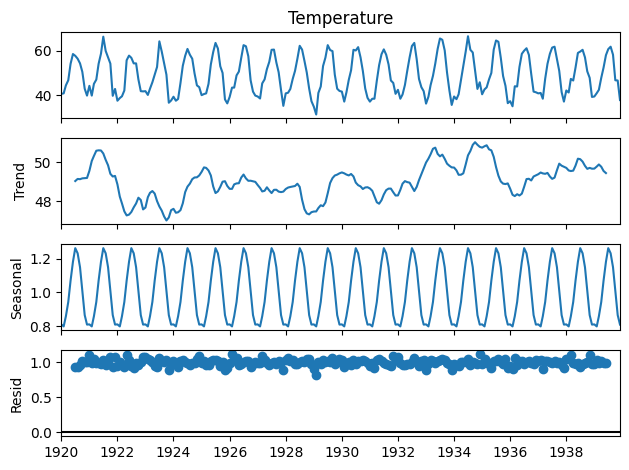

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer en tendencia, estacionalidad y residuo
result = seasonal_decompose(df['Temperature'], model='multiplicative', period=12)

# Mostrar la descomposición
result.plot()
plt.tight_layout()
plt.show()

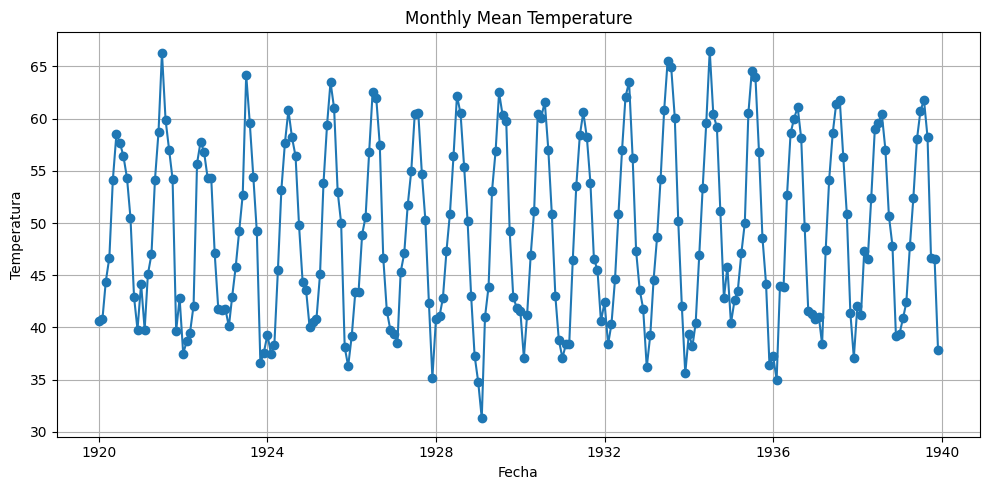

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Temperature'], marker='o', linestyle='-')
plt.title('Monthly Mean Temperature')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
train_size = int(len(df) * 0.7)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

### Promedios Moviles

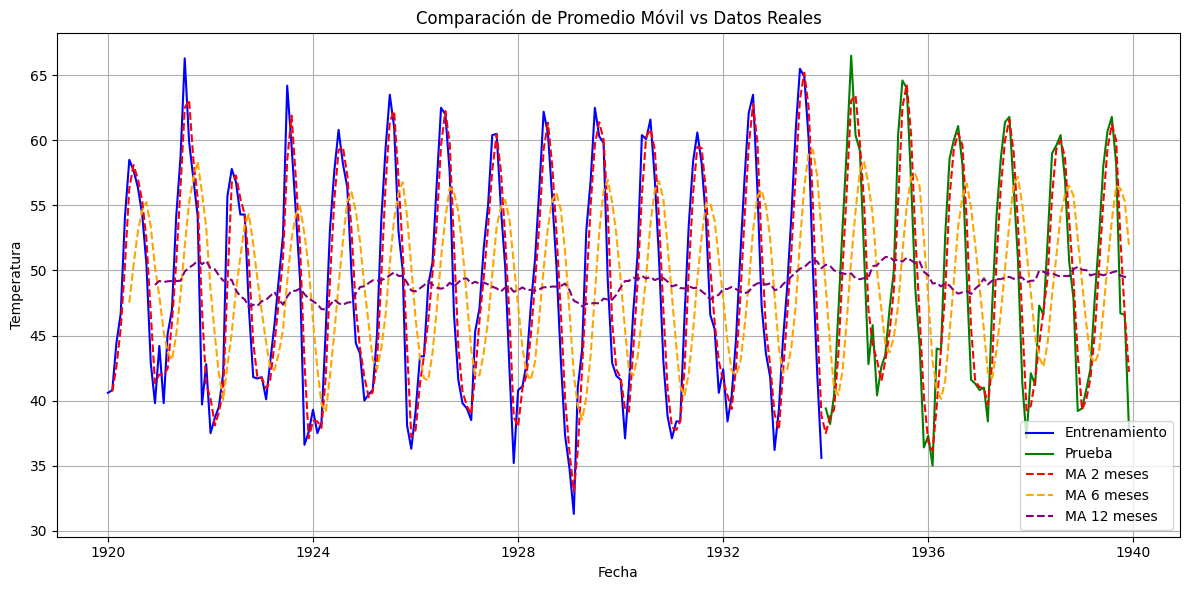

In [9]:
df['MA_2'] = df['Temperature'].rolling(window=2).mean()
df['MA_6'] = df['Temperature'].rolling(window=6).mean()
df['MA_12'] = df['Temperature'].rolling(window=12).mean()
ma_pred = df['MA_2'].loc[test.index]

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Temperature'], label='Prueba', color='green')
plt.plot(df.index, df['MA_2'], label='MA 2 meses', linestyle='--', color='red')
plt.plot(df.index, df['MA_6'], label='MA 6 meses', linestyle='--', color='orange')
plt.plot(df.index, df['MA_12'], label='MA 12 meses', linestyle='--', color='purple')

plt.title('Comparación de Promedio Móvil vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Aislamiento Exponencial

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


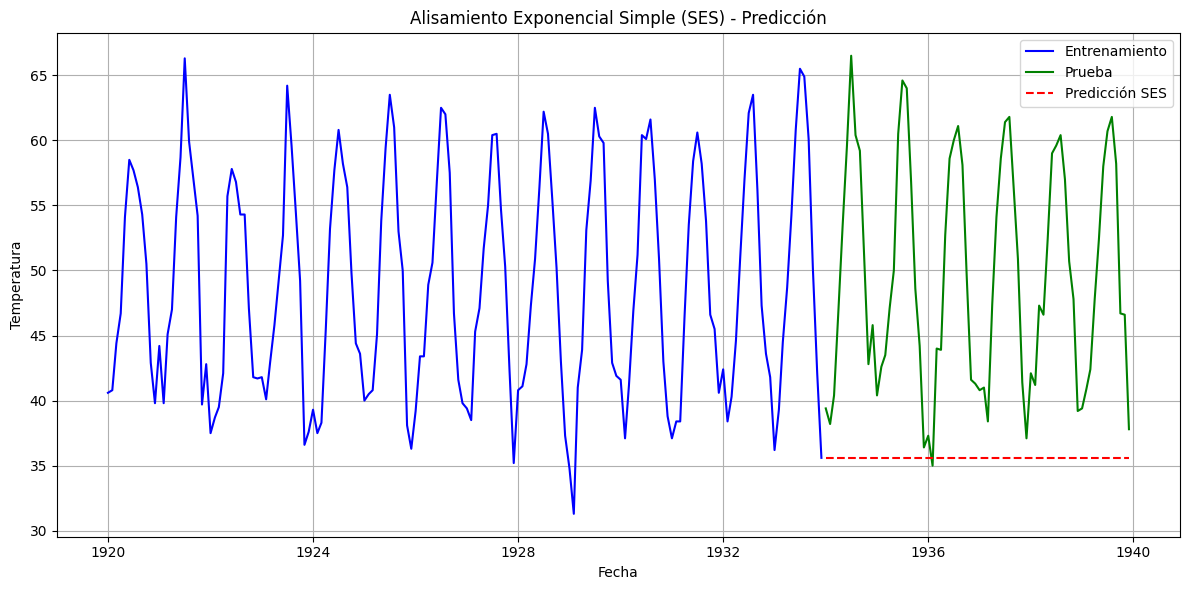

In [11]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


modelo = SimpleExpSmoothing(train['Temperature'])
modelo_ajustado = modelo.fit()

# Hacer predicción para el mismo horizonte que el conjunto de prueba
prediccion = modelo_ajustado.forecast(len(test))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Temperature'], label='Prueba', color='green')
plt.plot(prediccion.index, prediccion, label='Predicción SES', color='red', linestyle='--')

plt.title("Alisamiento Exponencial Simple (SES) - Predicción")
plt.xlabel("Fecha")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### HOLT-WINTERS


c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


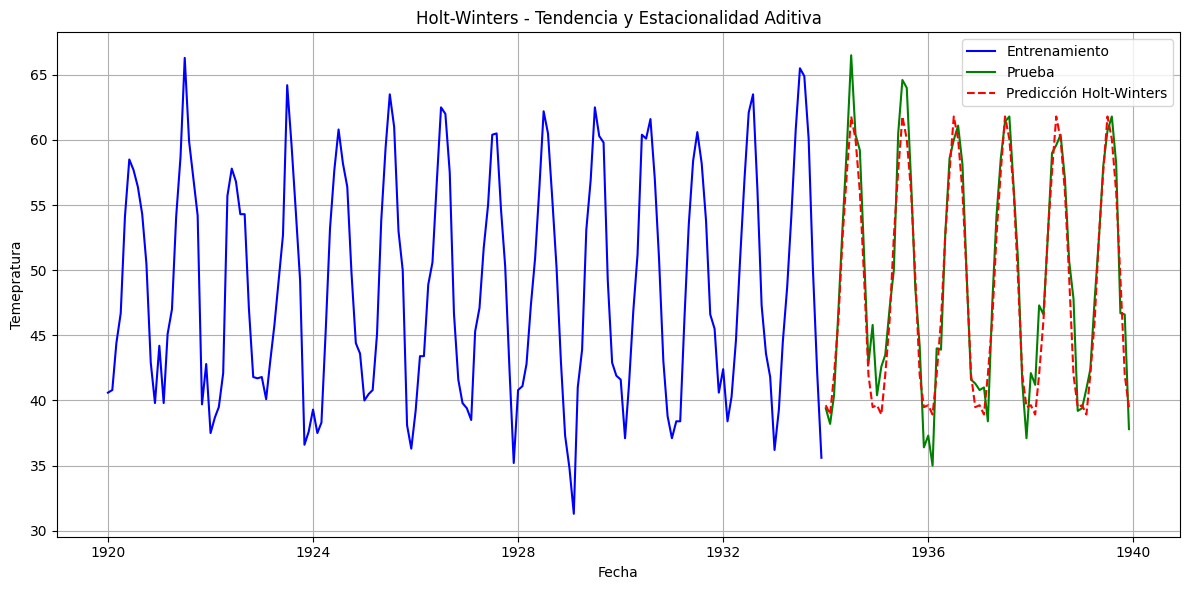

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

modelo_hw = ExponentialSmoothing(train['Temperature'],
                                 trend=None,
                                 seasonal='add',
                                 seasonal_periods=12).fit()

# Predicción para el periodo de prueba
pred_hw = modelo_hw.forecast(len(test))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Temperature'], label='Prueba', color='green')
plt.plot(pred_hw.index, pred_hw, label='Predicción Holt-Winters', color='red', linestyle='--')

plt.title("Holt-Winters - Tendencia y Estacionalidad Aditiva")
plt.xlabel("Fecha")
plt.ylabel("Temepratura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMA

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


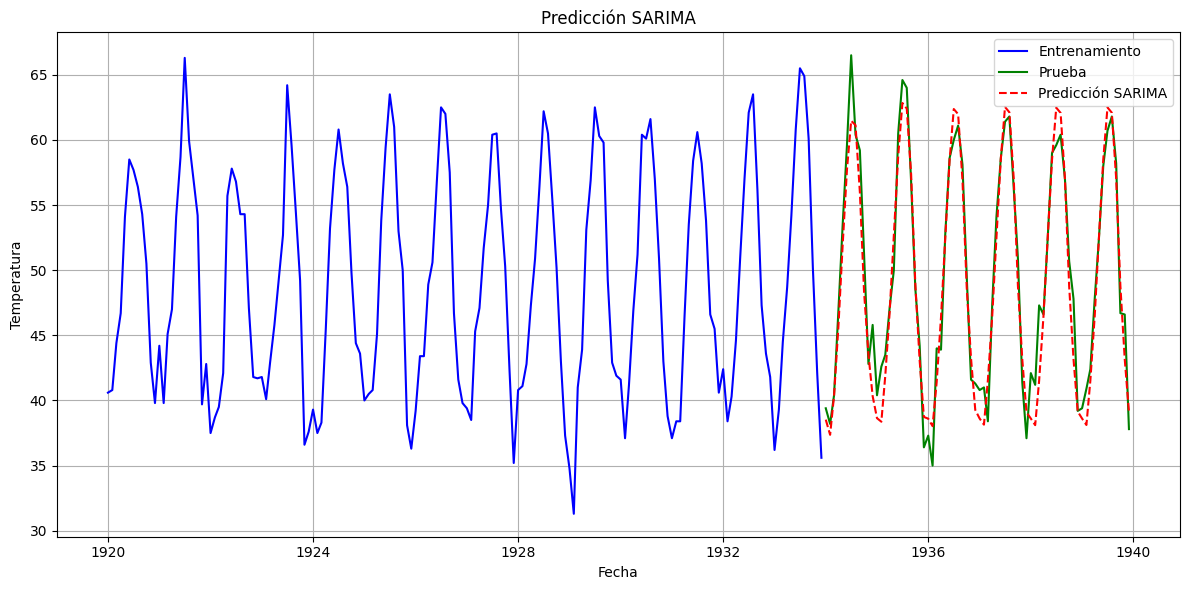

In [20]:
import statsmodels.api as sm

modelo_sarima = sm.tsa.statespace.SARIMAX(train['Temperature'],
                                          order=(1, 0, 1),
                                          seasonal_order=(1, 1, 1, 12)).fit()

pred_sarima = modelo_sarima.predict(start=len(train),
                                    end=len(train)+len(test)-1,
                                    dynamic=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Temperature'], label='Prueba', color='green')
plt.plot(pred_sarima.index, pred_sarima, label='Predicción SARIMA', color='red', linestyle='--')

plt.title("Predicción SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Prophet

Importing plotly failed. Interactive plots will not work.
15:58:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:58:55 - cmdstanpy - INFO - CmdStan done processing.
15:58:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


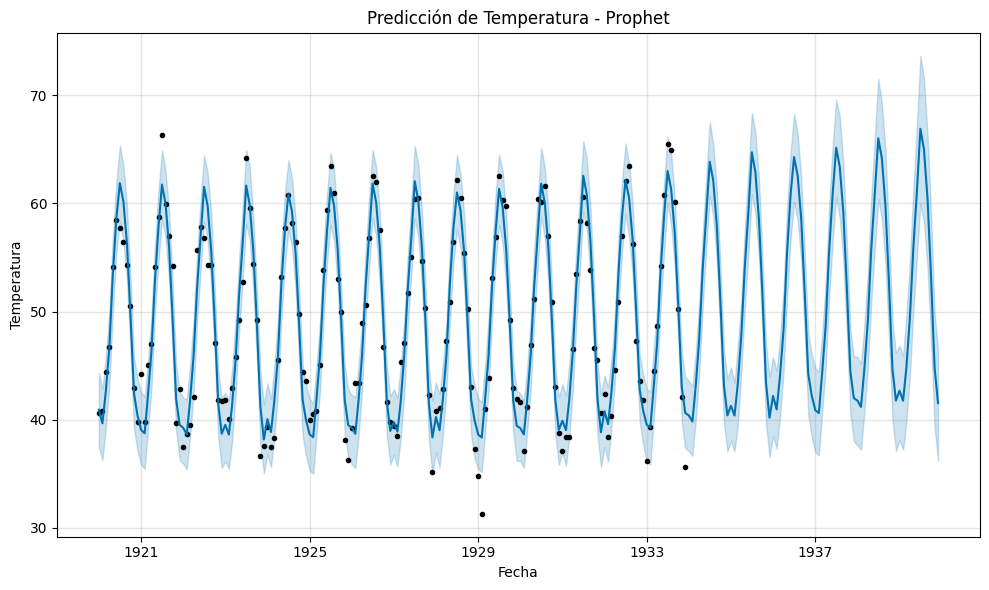

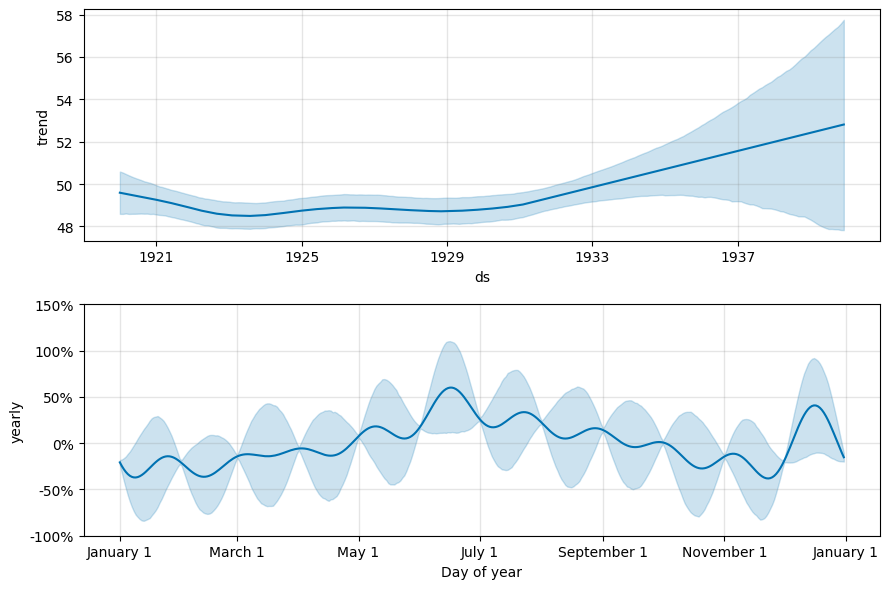

In [13]:
from prophet import Prophet

# Cargar y preparar datos
datos = pd.read_csv('./data/monthly-mean-temp.csv')
datos['ds'] = pd.to_datetime(datos['Month'])
datos['y'] = datos['Temperature'].astype(float)
datos = datos[['ds', 'y']]

# Separar en entrenamiento y prueba
train_size = int(len(datos) * 0.7)
train = datos.iloc[:train_size].copy()
test = datos.iloc[train_size:].copy()

# Crear y ajustar modelo Prophet
modelProphet = Prophet(seasonality_mode='multiplicative', mcmc_samples=500)
modelProphet_ajustado = modelProphet.fit(train)

# Crear fechas futuras para cubrir periodo de prueba
futuro = modelProphet_ajustado.make_future_dataframe(periods=len(test), freq='MS')

# Hacer predicciones
predicciones = modelProphet_ajustado.predict(futuro)

# Graficar predicciones
modelProphet.plot(predicciones)
plt.title('Predicción de Temperatura - Prophet')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar componentes
modelProphet.plot_components(predicciones)
plt.tight_layout()
plt.show()

# Extraer predicciones para periodo de prueba
# Asegurarse de que test['ds'] existe y es datetime
pred_test = predicciones.set_index('ds').loc[test['ds'], 'yhat']



### Comparacion Final

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluar(y_real, y_pred):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    return rmse, mae

y_true = test['y']

resultados = {
    'Promedios Mobiles': evaluar(y_true, ma_pred),
    'SES': evaluar(y_true, modelo_ajustado.forecast(len(test))),
    'Holt-Winters': evaluar(y_true, pred_hw),
    'SARIMA': evaluar(y_true, pred_sarima),
    'Prophet': evaluar(y_true, pred_test)
}

print("=== Comparación de Modelos ===")
for modelo, (rmse, mae) in resultados.items():
    print(f"{modelo}: RMSE = {rmse:.2f}, MAE = {mae:.2f}")


=== Comparación de Modelos ===
Promedios Mobiles: RMSE = 2.65, MAE = 2.17
SES: RMSE = 16.43, MAE = 14.01
Holt-Winters: RMSE = 2.25, MAE = 1.77
SARIMA: RMSE = 2.09, MAE = 1.69
Prophet: RMSE = 2.89, MAE = 2.36
